In [2]:
import numpy as np
from PIL import Image
import torch
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
from diffusers.utils import make_image_grid
from src.utils.mask_v2 import Maskerv2 as Masker
from src.utils.mask import get_mask_location
from src.preprocess.openpose import OpenPose
from src.preprocess.humanparsing import Parsing

In [3]:
def mask2agn(mask: np.array) -> Image.Image:
    mask = torch.from_numpy(mask)
    body_tensor = pil_to_tensor(body)
    agnostic_tensor = torch.where(mask, torch.ones_like(body_tensor) * 127, body_tensor)
    agn_img = to_pil_image(agnostic_tensor)
    return agn_img

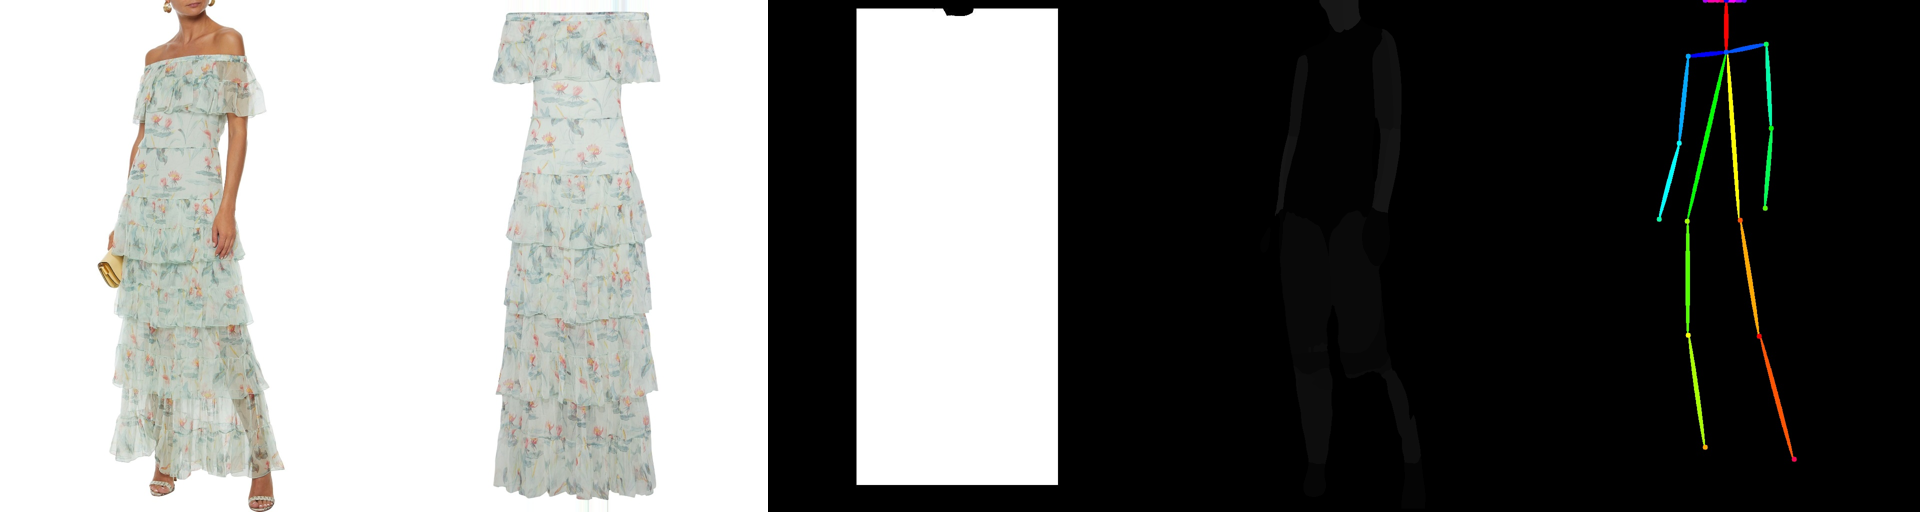

In [8]:
category = 'dresses'
body_path = f'/hosjiu/data/DressCode/{category}/images/020801_0.jpg'
garment_path = f'/hosjiu/data/DressCode/{category}/images/020801_1.jpg'
mask_path = f'/hosjiu/data/DressCode/{category}/mask_v2/020801_0.jpg'
dense_path = f'/hosjiu/data/DressCode/{category}/dense/020801_5.png'
uv_path = f'/hosjiu/data/DressCode/{category}/dense/020801_5_uv.npz'
skeleton_path = f'/hosjiu/data/DressCode/{category}/skeletons/020801_5.jpg'

w, h = (384, 512)
body = Image.open(body_path).resize((w, h))
garment = Image.open(garment_path).resize((w, h))
mask = Image.open(mask_path).resize((w, h))
dense = Image.open(dense_path).resize((w, h))
uv = np.load(uv_path)
skeleton = Image.open(skeleton_path).resize((w, h))

make_image_grid([body, garment, mask, dense, skeleton], rows=1, cols=5)

In [11]:
print(pil_to_tensor(dense).shape)
print(pil_to_tensor(skeleton).shape)

torch.Size([1, 512, 384])
torch.Size([3, 512, 384])


In [12]:
masker = Masker()

2024-12-19 04:04:36.477464708 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-12-19 04:04:36.477492133 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2024-12-19 04:04:37.087326052 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_

In [13]:
gpu_id = 0
human_parser = Parsing(gpu_id)
openpose = OpenPose(gpu_id)

2024-12-19 10:36:15.462025249 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_ort.cc:1637 onnxruntime::Provider& onnxruntime::ProviderLibrary::Get() [ONNXRuntimeError] : 1 : FAIL : Failed to load library libonnxruntime_providers_cuda.so with error: libcublasLt.so.12: cannot open shared object file: No such file or directory

2024-12-19 10:36:15.462057095 [W:onnxruntime:Default, onnxruntime_pybind_state.cc:965 CreateExecutionProviderInstance] Failed to create CUDAExecutionProvider. Require cuDNN 9.* and CUDA 12.*. Please install all dependencies as mentioned in the GPU requirements page (https://onnxruntime.ai/docs/execution-providers/CUDA-ExecutionProvider.html#requirements), make sure they're in the PATH, and that your GPU is supported.
2024-12-19 10:36:16.233316055 [E:onnxruntime:Default, provider_bridge_ort.cc:1992 TryGetProviderInfo_CUDA] /onnxruntime_src/onnxruntime/core/session/provider_bridge_

In [14]:
# mask v1
keypoints, _ = openpose(body)
body_parse, _  = human_parser(body)
mask_v1, mask_gray, tmp, _ = get_mask_location(
    model_type='hd',
    category='upper_body',
    model_parse=body_parse,
    keypoint=keypoints,
    width=w,
    height=h
)

# mask v2 (dilated-relaxed mask)
mask_v2 = masker.create_mask(body, category='upper_body', return_img=False)

100%|██████████| 1/1 [00:00<00:00,  1.80it/s]


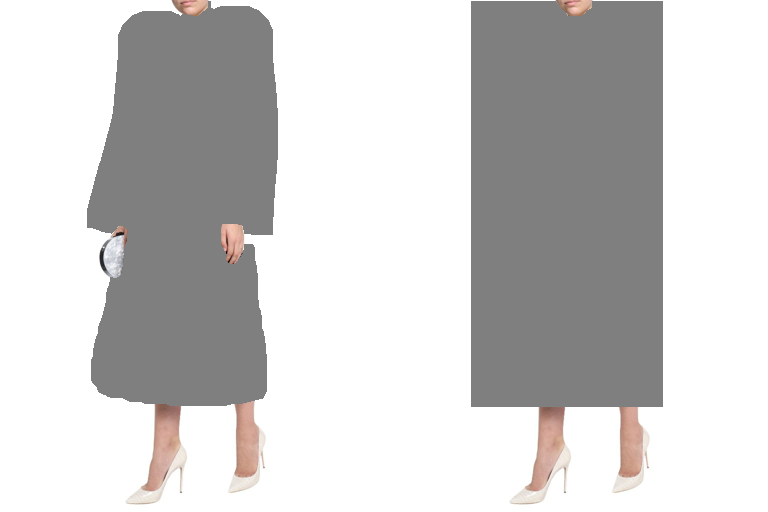

In [15]:
agn_v1 = mask2agn(np.array(mask_v1))
agn_v2 = mask2agn(np.array(mask_v2))
make_image_grid([agn_v1, agn_v2], rows=1, cols=2)

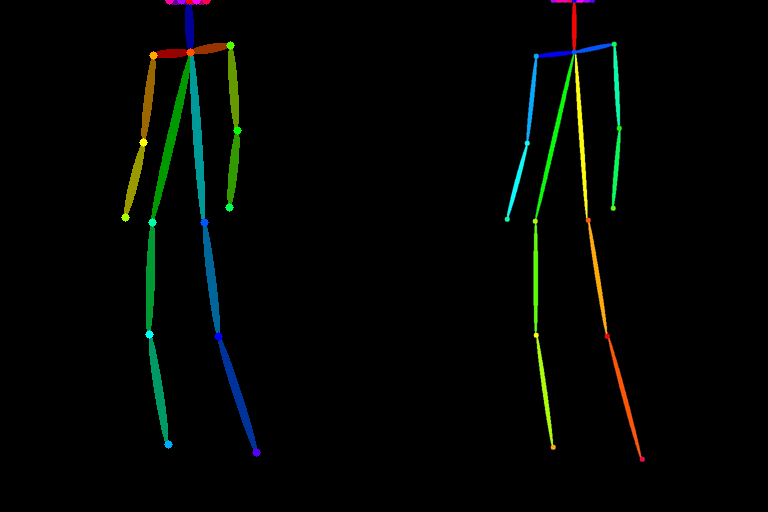

In [22]:
from einops import rearrange
import torchvision

detected_map = openpose(body)[1]
my_skeleton = Image.fromarray(detected_map)
my_skeleton = torchvision.transforms.Resize(w, interpolation=0)(my_skeleton)

make_image_grid([my_skeleton, skeleton], 1, 2)

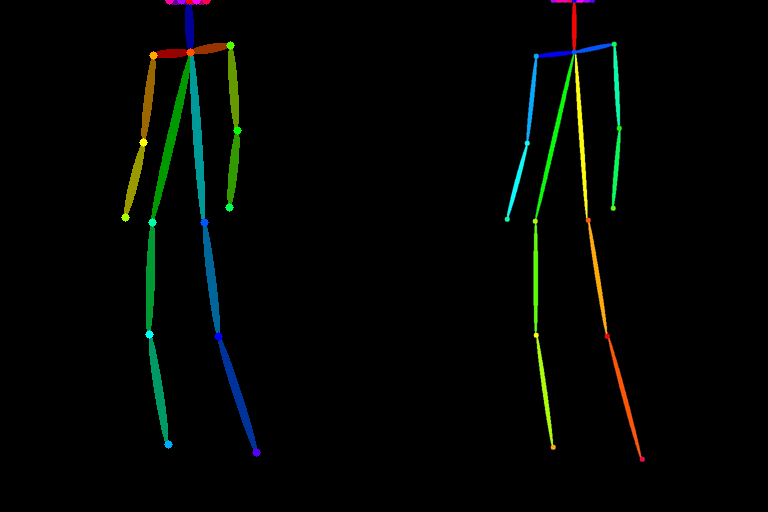

In [20]:
from einops import rearrange
import torchvision

detected_map = openpose(body)[1]
my_skeleton = Image.fromarray(detected_map)
# my_skeleton = torchvision.transforms.Resize(w, interpolation=2)(my_skeleton)

make_image_grid([my_skeleton, skeleton], 1, 2)